
=== RandomForest ===
              precision    recall  f1-score   support

           0     0.4000    0.2222    0.2857         9
           1     0.6129    1.0000    0.7600        19
           2     0.8000    0.3636    0.5000        11
           3     0.0000    0.0000    0.0000         2

    accuracy                         0.6098        41
   macro avg     0.4532    0.3965    0.3864        41
weighted avg     0.5865    0.6098    0.5491        41

Confusion Matrix:
 [[ 2  7  0  0]
 [ 0 19  0  0]
 [ 3  4  4  0]
 [ 0  1  1  0]]
Accuracy: 0.6098, CV F1-Macro: 0.3287

=== GradientBoosting ===
              precision    recall  f1-score   support

           0     0.2857    0.2222    0.2500         9
           1     0.6250    0.7895    0.6977        19
           2     0.3750    0.2727    0.3158        11
           3     0.0000    0.0000    0.0000         2

    accuracy                         0.4878        41
   macro avg     0.3214    0.3211    0.3159        41
weighted avg     0.

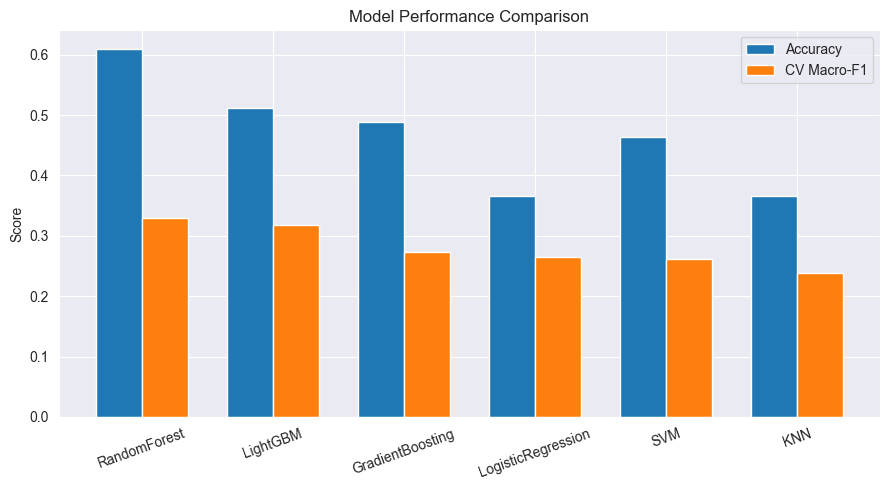

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from pathlib import Path
import warnings

# 忽略无关警告
warnings.filterwarnings("ignore")

# ==== 参数 ====
TEST_SIZE = 0.2
RANDOM_STATE = 42
out_dir = Path("./results")
out_dir.mkdir(exist_ok=True)

# ==== 读取特征文件 ====
df = pd.read_csv(r"C:\Users\mxjli\PyCharmMiscProject\final_outputs\features.csv")

# ==== 自动识别并排除非数值列 ====
if 'path' in df.columns:
    feat_cols = [c for c in df.columns if c not in ['path', 'label']]
else:
    feat_cols = [c for c in df.columns if c != 'label']

X = df[feat_cols].values
y = df['label'].values

# ==== 标准化 ====
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# ==== 划分训练/测试 ====
X_tr, X_te, y_tr, y_te = train_test_split(
    Xs, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ==== 定义多个分类器（加入 LightGBM） ====
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_STATE, class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(
        max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced"
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, random_state=RANDOM_STATE, class_weight="balanced"
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=7,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        verbose=-1
    )
}

# ==== 交叉验证 ====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ==== 存储结果 ====
results = []

for name, clf in models.items():
    print(f"\n=== {name} ===")
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    # 计算指标
    acc = accuracy_score(y_te, y_pred)
    f1_cv = cross_val_score(clf, Xs, y, cv=cv, scoring="f1_macro").mean()

    # 输出报告
    report = classification_report(y_te, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)

    print(report)
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, CV F1-Macro: {f1_cv:.4f}")

    # 写入文本文件
    with open(out_dir / f"{name}_report.txt", "w", encoding="utf-8") as f:
        f.write(report + "\n\nConfusion Matrix:\n")
        for row in cm:
            f.write(" ".join(map(str, row)) + "\n")
        f.write(f"\nAccuracy: {acc:.4f}\nCV F1-Macro: {f1_cv:.4f}\n")

    # 保存结果到表格
    results.append({
        "Model": name,
        "Accuracy": acc,
        "CV_F1_Macro": f1_cv
    })

# ==== 汇总表格 ====
results_df = pd.DataFrame(results).sort_values(by="CV_F1_Macro", ascending=False)
results_df.to_csv(out_dir / "results_summary.csv", index=False)
print("\n📊 Summary saved to results_summary.csv")
print(results_df)

# ==== 可视化 ====
plt.figure(figsize=(9, 5))
bar_width = 0.35
x = np.arange(len(results_df))

plt.bar(x - bar_width/2, results_df["Accuracy"], width=bar_width, label="Accuracy")
plt.bar(x + bar_width/2, results_df["CV_F1_Macro"], width=bar_width, label="CV Macro-F1")

plt.xticks(x, results_df["Model"], rotation=20)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", message="X does not have valid feature names")

# ============================================================
# 1️⃣ Data Loading and Preprocessing
# ============================================================
df = pd.read_csv(r"C:\Users\mxjli\PyCharmMiscProject\final_outputs\features.csv")

out_dir = Path(r"C:\Users\mxjli\PyCharmMiscProject\final_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

feat_cols = df.columns[:24]
X = df[feat_cols]
y = df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# 2️⃣ Define Model and Search Space
# ============================================================
clf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

# Random Forest hyperparameter search space
param_dist = {
    "n_estimators": [600, 800, 1000, 1200, 1500],
    "max_depth": [None, 5, 7, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", 0.5, 0.8],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"]
}

# ============================================================
# 3️⃣ Cross-Validation and Scoring Function
# ============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average="macro")

# ============================================================
# 4️⃣ Randomized Search
# ============================================================
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=40,                  # Number of random search iterations
    scoring="accuracy",         # Evaluation metric (can use f1_macro as well)
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_scaled, y)

# ============================================================
# 5️⃣ Output the Best Results
# ============================================================
print("\n===== Best Parameters =====")
for k, v in search.best_params_.items():
    print(f"{k}: {v}")
print(f"\nBest Macro-F1 Score: {search.best_score_:.4f}")

# Save the best results
result_path = out_dir / "rf_hyperopt_results.txt"
with open(result_path, "w", encoding="utf-8") as f:
    f.write("===== Best Parameters =====\n")
    for k, v in search.best_params_.items():
        f.write(f"{k}: {v}\n")
    f.write(f"\nBest Macro-F1: {search.best_score_:.4f}\n")

print(f"\n✅ Results have been saved to {result_path}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits

===== Best Parameters =====
n_estimators: 600
min_samples_split: 5
min_samples_leaf: 1
max_features: log2
max_depth: 20
criterion: gini
bootstrap: True

Best Macro-F1 Score: 0.5298

✅ Results have been saved to C:\Users\mxjli\PyCharmMiscProject\final_outputs\rf_hyperopt_results.txt
